#Interpretacja tematu projektu

Wybrany temat to „Tworzenie zespołu modeli klasyfikacji przez wielokrotne stosowanie dowolnego algorytmu klasyfikacji do bootstrapowych prób ze zbioru trenującego z losowo wybranym podzbiorem atrybutów. Porównanie z algorytmami klasyfikacji tworzącymi pojedyncze modele oraz implementacją algorytmów bagging i random forest dostępnymi w środowisku R lub Python.”


Zgodnie z ustaleniami podczas konsultacji tematu, część implementacyjna będzie polegała na napisaniu kodu, który umożliwiał będzie tworzenie zespołu modeli klasyfikacji, gdzie każdy taki model będzie uczył się na kolejnej próbie bootstrapowej. W założeniu do wyboru będą dostępne zaimplementowane algorytmy takie jak DecisionTreeClassifier czy GaussianNB.


Do podejmowania decyzji o klasyfikacji będzie wykorzystywane głosowanie większościowe.


Celem będzie porównanie wyników tak utworzonego zespołu modeli z pojedynczymi modelami dostępnymi w środowisku Python, aby sprawdzić czy zwiększenie ilości modeli polepszy wyniki klasyfikacji. Porównywane też będą wyniki zespołów modeli bagging i random forest, które dostępne są w języku Python.

Dodatkowo porównamy też wyniki dwóch implementacji funkcji predict_proba. Funkcja ta zwraca prawdopodobieństwa, że dane należą do konkretnych klas. predict_proba została zaimplementowana poprzez uśrednienie metody predict_proba generowanych przez zespół modeli. predict_proba2 natomiast wykorzystuje głosowanie poszczególnych modeli do policzenia prawdopodobieństw.

# Wybór czy wersja przyspieszona

In [1]:
fast_version = False # True

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Przedstawienie charakterystyki danych oraz ich przygotowanie do uczenia 

In [3]:
! mkdir /content/input_ready
! mkdir /content/input_ready/AirlinePassengerSatisfaction
! mkdir /content/input_ready/CarEvaluationDataSet

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data

--2023-05-17 09:14:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51867 (51K) [application/x-httpd-php]
Saving to: ‘car.data’

car.data            100%[===================>]  50.65K  --.-KB/s    in 0.1s    

2023-05-17 09:14:19 (372 KB/s) - ‘car.data’ saved [51867/51867]



Dane CarEvaluationDataSet zostały pobrane ze strony https://archive.ics.uci.edu/ml/datasets/car+evaluation. 

Zawiera on 6 atrybutów za pomocą których będziemy przewidywać klasę oceny ('Evaluation') samochodu.

Klasa oceny samochodu ma 4 wartości. Ich częstość występowania rozkłada się jak poniżej. Jest to zbiór niezbalansowany.


*   unacc (niedopuszczalna), 70.02%
*   acc (akceptowalna), 22.22%
*   good (dobra), 3.99%
*   v-good (bardzo dobra), 3.76%


In [5]:
import pandas as pd
df = pd.read_csv("car.data", names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'Evaluation'])
df.head()

,buying,maint,doors,persons,lug_boot,safety,Evaluation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [6]:
for col in df:
    print(col)
    print(round(df[col].value_counts()/df[col].count()*100, 2))

buying
vhigh    25.0
high     25.0
med      25.0
low      25.0
Name: buying, dtype: float64
maint
vhigh    25.0
high     25.0
med      25.0
low      25.0
Name: maint, dtype: float64
doors
2        25.0
3        25.0
4        25.0
5more    25.0
Name: doors, dtype: float64
persons
2       33.33
4       33.33
more    33.33
Name: persons, dtype: float64
lug_boot
small    33.33
med      33.33
big      33.33
Name: lug_boot, dtype: float64
safety
low     33.33
med     33.33
high    33.33
Name: safety, dtype: float64
Evaluation
unacc    70.02
acc      22.22
good      3.99
vgood     3.76
Name: Evaluation, dtype: float64


Jako że atrybuty powyżej są dyskretne porządkowe postanowiliśmy zakodować je w taki sposób aby nie tracić tej informacji.

In [7]:
mapper = {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3, '2': 2, '3': 3, '4': 4, 'more': 5, '5more': 5, 'small': 0, 'med': 1, 'big': 2, 'unacc': 0 ,'acc': 1, 'good': 2, 'vgood': 3}

In [8]:
for col in df:
  df[col] = df[col].map(mapper)

In [9]:
for col in df:
    print(col)
    print(round(df[col].value_counts()/df[col].count()*100, 2))

buying
3    25.0
2    25.0
1    25.0
0    25.0
Name: buying, dtype: float64
maint
3    25.0
2    25.0
1    25.0
0    25.0
Name: maint, dtype: float64
doors
2    25.0
3    25.0
4    25.0
5    25.0
Name: doors, dtype: float64
persons
2    33.33
4    33.33
5    33.33
Name: persons, dtype: float64
lug_boot
0    33.33
1    33.33
2    33.33
Name: lug_boot, dtype: float64
safety
0    33.33
1    33.33
2    33.33
Name: safety, dtype: float64
Evaluation
0    70.02
1    22.22
2     3.99
3     3.76
Name: Evaluation, dtype: float64


In [10]:
df.to_csv("/content/input_ready/CarEvaluationDataSet/carData.csv", index=False)

Dane AirlinePassengerSatisfaction ze strony https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction. 

Zawiera on około 130k rekordów, co czyni go o wiele większym od poprzedniego. Posiada on 22 atrybuty.

Aby modele drzew nie rozrosły się za bardzo atrybutom ciągłym zostaną przypisane kategorie. Przykładowo dla wieku pasażerów powstaną kategorie dzieci, młodzież, dorośli, seniorzy.

Zbiór ten jest zbilansowany. Około 43% respondentów uważa się za usatysfakcjonowanych.

In [11]:
!wget https://raw.githubusercontent.com/yogeshwaran-shanmuganathan/Airline-Passenger-Satisfaction/master/Data/test.csv
!wget https://raw.githubusercontent.com/yogeshwaran-shanmuganathan/Airline-Passenger-Satisfaction/master/Data/train.csv

--2023-05-17 09:14:20--  https://raw.githubusercontent.com/yogeshwaran-shanmuganathan/Airline-Passenger-Satisfaction/master/Data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3037688 (2.9M) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]   2.90M  --.-KB/s    in 0.02s   

2023-05-17 09:14:20 (162 MB/s) - ‘test.csv’ saved [3037688/3037688]

--2023-05-17 09:14:20--  https://raw.githubusercontent.com/yogeshwaran-shanmuganathan/Airline-Passenger-Satisfaction/master/Data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent

In [12]:
df1 = pd.read_csv("test.csv")
df2 = pd.read_csv("train.csv")
df = df1.append(df2, ignore_index=True)
df.drop(columns=["Unnamed: 0","id"],inplace=True)
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,129880.0,39.427957,15.119360,7.0,27.0,40.0,51.0,85.0
Flight Distance,129880.0,1190.316392,997.452477,31.0,414.0,844.0,1744.0,4983.0
Inflight wifi service,129880.0,2.728696,1.329340,0.0,2.0,3.0,4.0,5.0
Departure/Arrival time convenient,129880.0,3.057599,1.526741,0.0,2.0,3.0,4.0,5.0
Ease of Online booking,129880.0,2.756876,1.401740,0.0,2.0,3.0,4.0,5.0
Gate location,129880.0,2.976925,1.278520,0.0,2.0,3.0,4.0,5.0
Food and drink,129880.0,3.204774,1.329933,0.0,2.0,3.0,4.0,5.0
Online boarding,129880.0,3.252633,1.350719,0.0,2.0,3.0,4.0,5.0
Seat comfort,129880.0,3.441361,1.319289,0.0,2.0,4.0,5.0,5.0
Inflight entertainment,129880.0,3.358077,1.334049,0.0,2.0,4.0,4.0,5.0


In [14]:
for col in df:
    if col not in ["Age", "Departure Delay in Minutes", "Arrival Delay in Minutes", "Flight Distance"]:
      print(col, df[col].unique())

Gender ['Female' 'Male']
Customer Type ['Loyal Customer' 'disloyal Customer']
Type of Travel ['Business travel' 'Personal Travel']
Class ['Eco' 'Business' 'Eco Plus']
Inflight wifi service [5 1 2 0 3 4]
Departure/Arrival time convenient [4 1 0 3 5 2]
Ease of Online booking [3 2 0 4 5 1]
Gate location [4 1 2 3 5 0]
Food and drink [3 5 2 4 1 0]
Online boarding [4 2 1 5 3 0]
Seat comfort [3 5 2 4 1 0]
Inflight entertainment [5 4 2 1 3 0]
On-board service [5 4 1 2 3 0]
Leg room service [5 4 1 2 3 0]
Baggage handling [5 4 3 1 2]
Checkin service [2 3 4 1 5 0]
Inflight service [5 4 2 1 3 0]
Cleanliness [5 2 4 3 1 0]
satisfaction ['satisfied' 'neutral or dissatisfied']


Poniżej został przedstawiony rozkład 4 atrybutów ciągłych. Zostaną one zmienione na atrybuty kategoryczne.

<Axes: xlabel='Departure Delay in Minutes', ylabel='Density'>

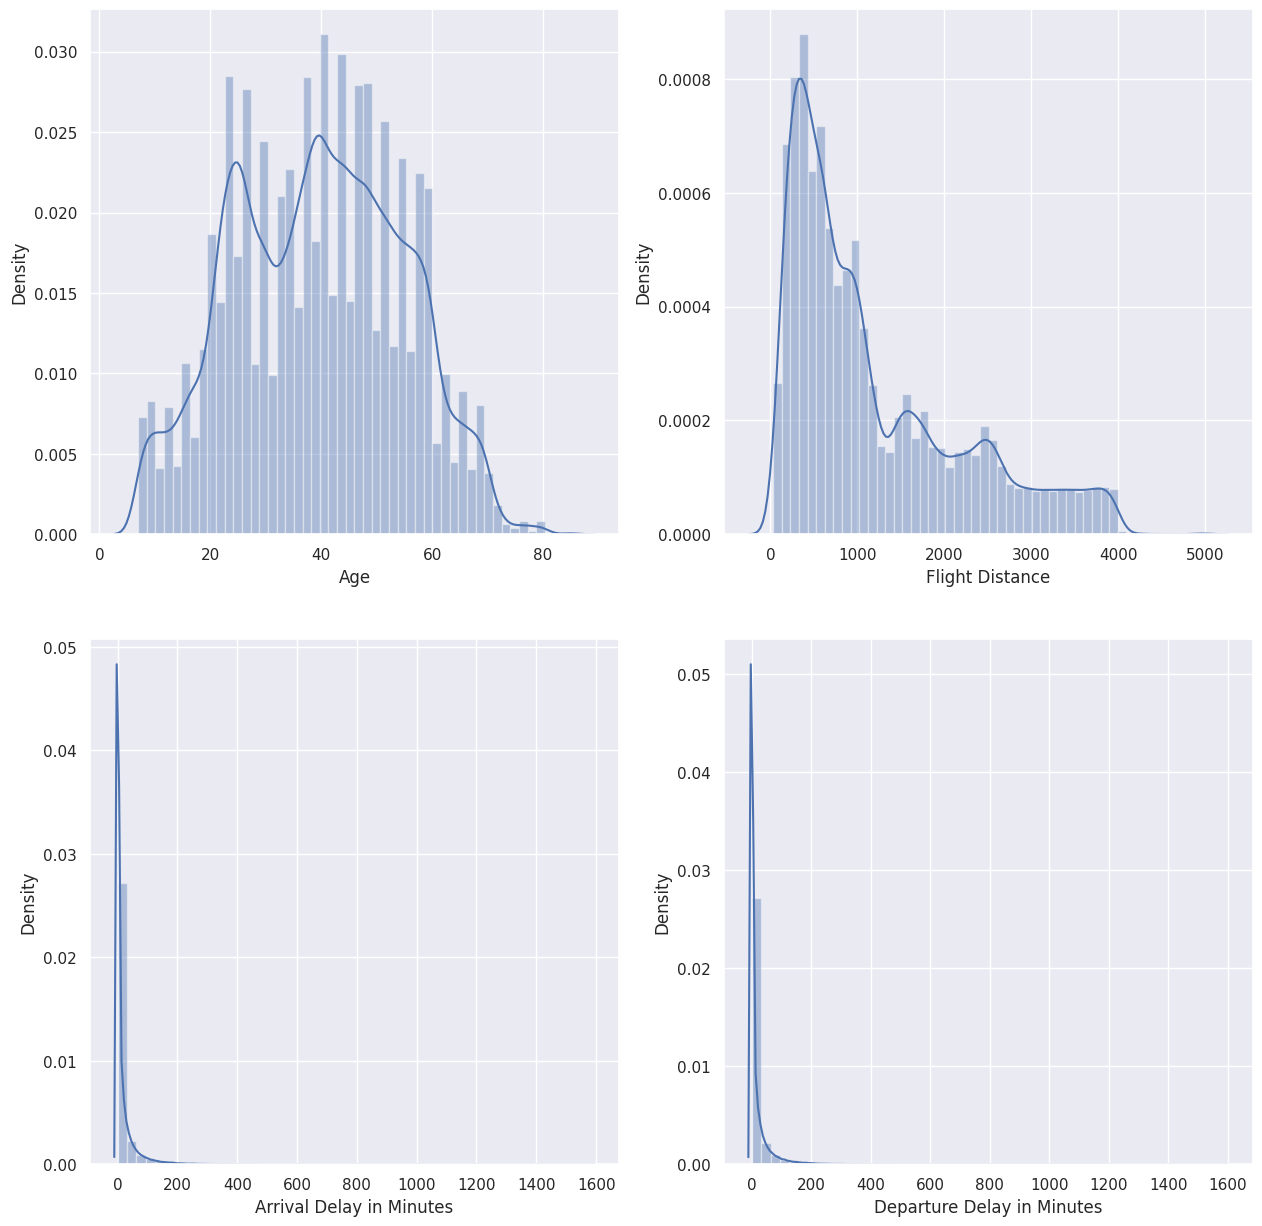

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from pylab import *
sns.set(rc={"figure.figsize": (15, 15)})
subplot(2,2,1)
sns.distplot(df["Age"])
subplot(2,2,2)
sns.distplot(df["Flight Distance"])
subplot(2,2,3)
sns.distplot(df["Arrival Delay in Minutes"])
subplot(2,2,4)
sns.distplot(df["Departure Delay in Minutes"])

Stworzenie kolumn z kategoriami na podstawie wartości liczbowych

In [16]:
df["Age"] = pd.cut(df.Age, [0,14,25,60, np.inf], labels=['0','1','2',"3"]) # ['child','youth','adult',"senior_citizen"]
df["Arrival Delay in Minutes"].fillna(0,inplace=True)
df['Flight Distance'] = pd.qcut(df['Flight Distance'], q=3, labels=['0', '1', '2']) # ['small', 'medium', 'big']
df['Departure Delay in Minutes'] = pd.cut(df['Departure Delay in Minutes'], [-0.1,12, np.inf], labels=['0', '1']) # ['small', 'big']
df['Arrival Delay in Minutes'] = pd.cut(df['Arrival Delay in Minutes'], [-0.1,13, np.inf], labels=['0', '1']) # ['small', 'big']

In [17]:
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,2,Business travel,Eco,0,5,4,3,4,...,5,5,5,5,2,5,5,1,1,satisfied
1,Female,Loyal Customer,2,Business travel,Business,2,1,1,3,1,...,4,4,4,4,3,4,5,0,0,satisfied
2,Male,disloyal Customer,1,Business travel,Eco,0,2,0,2,4,...,2,4,1,3,2,2,2,0,0,neutral or dissatisfied
3,Male,Loyal Customer,2,Business travel,Business,2,0,0,0,2,...,1,1,1,1,3,1,4,0,0,satisfied
4,Female,Loyal Customer,2,Business travel,Eco,1,2,3,4,3,...,2,2,2,2,4,2,4,0,1,satisfied


In [18]:
for col in df:
    print(col)
    print(round(df[col].value_counts()/df[col].count()*100, 2))

Gender
Female    50.74
Male      49.26
Name: Gender, dtype: float64
Customer Type
Loyal Customer       81.69
disloyal Customer    18.31
Name: Customer Type, dtype: float64
Age
2    70.57
1    16.72
3     7.74
0     4.97
Name: Age, dtype: float64
Type of Travel
Business travel    69.06
Personal Travel    30.94
Name: Type of Travel, dtype: float64
Class
Business    47.86
Eco         44.89
Eco Plus     7.25
Name: Class, dtype: float64
Flight Distance
0    33.43
2    33.33
1    33.24
Name: Flight Distance, dtype: float64
Inflight wifi service
2    24.88
3    24.78
4    19.08
1    17.19
5    11.05
0     3.02
Name: Inflight wifi service, dtype: float64
Departure/Arrival time convenient
4    24.55
5    21.56
3    17.23
2    16.58
1    14.94
0     5.14
Name: Departure/Arrival time convenient, dtype: float64
Ease of Online booking
3    23.40
2    23.14
4    18.82
1    16.85
5    13.42
0     4.37
Name: Ease of Online booking, dtype: float64
Gate location
3    27.50
4    23.46
2    18.71
1    16.

In [19]:
columns = ['Gender','Customer Type', 'Type of Travel', 'Class', 'satisfaction']
mapper = {'Female': 0, 'Male': 1, 'Loyal Customer': 1, 'disloyal Customer':0, 'Business travel': 1, 'Personal Travel': 0, 'Business': 0, 'Eco': 1, 'Eco Plus': 2, 'neutral or dissatisfied': 0 ,'satisfied': 1}
for col in columns:
  df[col] = df[col].map(mapper)

In [20]:
for col in df:
    print(col)
    print(round(df[col].value_counts()/df[col].count()*100, 2))

Gender
0    50.74
1    49.26
Name: Gender, dtype: float64
Customer Type
1    81.69
0    18.31
Name: Customer Type, dtype: float64
Age
2    70.57
1    16.72
3     7.74
0     4.97
Name: Age, dtype: float64
Type of Travel
1    69.06
0    30.94
Name: Type of Travel, dtype: float64
Class
0    47.86
1    44.89
2     7.25
Name: Class, dtype: float64
Flight Distance
0    33.43
2    33.33
1    33.24
Name: Flight Distance, dtype: float64
Inflight wifi service
2    24.88
3    24.78
4    19.08
1    17.19
5    11.05
0     3.02
Name: Inflight wifi service, dtype: float64
Departure/Arrival time convenient
4    24.55
5    21.56
3    17.23
2    16.58
1    14.94
0     5.14
Name: Departure/Arrival time convenient, dtype: float64
Ease of Online booking
3    23.40
2    23.14
4    18.82
1    16.85
5    13.42
0     4.37
Name: Ease of Online booking, dtype: float64
Gate location
3    27.50
4    23.46
2    18.71
1    16.93
5    13.40
0     0.00
Name: Gate location, dtype: float64
Food and drink
4    23.53
5   

In [21]:
if fast_version:
  df = df.sample(frac = 0.25)
df.to_csv("/content/input_ready/AirlinePassengerSatisfaction/airlineData.csv", index=False)

# Metoda do tworzenia zespołu modeli

In [22]:
import random
from statistics import mode
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
class ModelsBand:
  def __init__(self, model, model_size: int, bootstrap_size: int, attributes_size: int, column_y: str):
    random.seed(0)
    self.models_to_chose_from = {'DecisionTreeClassifier': DecisionTreeClassifier, 'GaussianNB': GaussianNB, 'CategoricalNB': CategoricalNB}
    self.model = model
    self.models = []
    self.model_size = model_size
    self.bootstrap_size = bootstrap_size
    self.attributes_size = attributes_size
    self.column_y = column_y
    self.classes = None

  def fit(self, X, y, **kwargs):
    X_copy = X.copy()
    X_copy[self.column_y] = y.copy()
    self.classes = set(y)
    for _ in range(self.model_size):
      data_new = self.bootstrap_sample(X_copy)
      Y_new = data_new[self.column_y]
      X_new = data_new.drop(columns=[self.column_y])
      X_new = self.choose_random_atributes(X_new)
      if self.model == 'DecisionTreeClassifier':
        clf = self.models_to_chose_from[self.model](random_state=0)
      else:
        clf = self.models_to_chose_from[self.model]()
      clf.fit(X_new,Y_new)
      self.models.append(clf)

  def get_params(self, deep = False):
        return {'bootstrap_size':self.bootstrap_size, 'attributes_size':self.attributes_size, 'model_size':self.model_size, 'model':self.model, 'column_y':self.column_y}

  def predict(self, X):
    column_names = list(X.columns.values)
    results = []
    for model in self.models:
      columns_to_delete = list(set(column_names) - set(model.feature_names_in_))
      results.append(model.predict(X.drop(columns=columns_to_delete)))
    results_for_every = []
    for idx in range(len(results[0])):
      results_for_x = []
      for result in results:
        results_for_x.append(result[idx])
      results_for_every.append(mode(results_for_x))
    return results_for_every

  def predict_proba(self, X):
      column_names = list(X.columns.values)
      results = []
      for model in self.models:
        columns_to_delete = list(set(column_names) - set(model.feature_names_in_))
        results.append(model.predict_proba(X.drop(columns=columns_to_delete)))
      results_for_every = []
      for idx in range(len(results[0])):
        results_for_x = []
        for result in results:
          results_for_x.append(result[idx])
        results_for_every.append(np.mean(results_for_x, axis=0))
      return results_for_every

  def predict_proba2(self, X):
      column_names = list(X.columns.values)
      results = []
      for model in self.models:
        columns_to_delete = list(set(column_names) - set(model.feature_names_in_))
        results.append(model.predict(X.drop(columns=columns_to_delete)))
      results_for_every = []
      for idx in range(len(results[0])):
        results_for_x = []
        for result in results:
          results_for_x.append(result[idx])
        ret = [results_for_x.count(x) for x in self.classes]
        ret = ret / np.sum(ret)
        results_for_every.append(ret)
      return results_for_every

  def choose_random_atributes(self, data: pd.DataFrame) -> pd.DataFrame:
    if(self.attributes_size > len(list(data.columns.values))):
      return data
    column_names = list(data.columns.values)
    column_names_new = []
    for _ in range(self.attributes_size):
      index = random.randint(0,len(column_names)-1)
      name = column_names[index]
      column_names_new.append(name)
      column_names.remove(name)
    columns_to_delete = list(set(list(data.columns.values)) - set(column_names_new))
    return data.drop(columns=columns_to_delete)

  def bootstrap_sample(self, data: pd.DataFrame) -> pd.DataFrame:
    return data.sample(n = self.bootstrap_size, replace = True, random_state=0)

# Pobranie przygotowanych zbiorow

In [23]:
df_car_data = pd.read_csv("/content/input_ready/CarEvaluationDataSet/carData.csv")
Y_car_data = df_car_data["Evaluation"]
X_car_data = df_car_data.drop(columns=["Evaluation"])
df_airline_data = pd.read_csv("/content/input_ready/AirlinePassengerSatisfaction/airlineData.csv")
Y_airline_data = df_airline_data["satisfaction"]
X_airline_data = df_airline_data.drop(columns=["satisfaction"])

# Funkcje pomocznice przydatne podczas przeprowadzania eksperymentów.

Funkcja służąca do wyświetlania wyników.

In [24]:
def print_scores(scores, **kwargs):
  for key, score in scores.items():
    if key == 'test_accuracy':
      if kwargs:
        string = f"Test accuracy scores for"
        for key, value in kwargs.items():
          string += f" {key} {value}"
        string += f":\n{np.mean(score)}"
        print(string)
      else:
        string = f"Test accuracy score:\n{np.mean(score)}"
        print(string)

In [25]:
def itarate_over_args(kwargs):
  for key, values in kwargs.items():
    for value in values:
      yield key, value

In [26]:
def generate_new_args(args, best_args, key, value):
  new_args = best_args.copy()
  new_args[key] = value
  for k in args:
    if k not in new_args:
      new_args[k] = args[k]
  return new_args

Funkcja służąca jako benchmark ustalająca optymalne wartości różnego rodzaju algorytmów. Przyjmuje jako parametry zbior trenujący, delte - mówi ona o tym jak duży zysk musi algorytm osiągnąć, aby opłacało się zwiększyć wartość danego parametru. Nie zawsze chcemy aby parametry były jak największe, ponieważ może to wpływać na czas obliczeń. Jeśli różnica w działaniu algorytmu jest mniejsza niż delta, pozostajemy przy starych wartościach danego parametru. Funkcja może optymalizwoać dowolne parametry. Ważne jest jedynie aby wartości do zbadania były przekazywane jako lista. Algorytm wybiera parametry do optymalizacji w kolejności ich przekazania do funkcji benchmark. Po ustaleniu optymalnej wartości jednego parametru jest ona zapamiętywana i wykorzystywana przy optymalizacji następnych. Dzięki temu nie musimy zakładać, że parametry są od siebie niezależne. Funkcja ta wykorzystuje walidację krzyżową, a metryką porównawczą jest dokładność testu (test accuracy).

In [27]:
from sklearn.model_selection import cross_validate

def benchmark(X, Y, delta, **kwargs):
  best_score = 0
  best_args = {}
  args = {i:kwargs[i][0] for i in kwargs}
  for key, value in itarate_over_args(kwargs):
    new_args = generate_new_args(args, best_args, key, value)
    score = cross_validate(ModelsBand(**new_args), X, Y, scoring=['accuracy'])
    score = np.mean(score['test_accuracy'])
    if key not in best_args or score - best_score > delta:
      best_args[key] = value
      best_score = score
    print(new_args, score)
    print("Best arguments so far: ", best_args)
  return best_args

In [28]:
bootstrap_size_car = [100, 1000]
attributes_size_car = [3, 4, 5, 6]
model_size_car = [5, 7, 9, 11, 13, 15, 17, 19 ,20]


bootstrap_size_airline = [100, 1000, 10000, 100000]
attributes_size_airline = [11, 13, 15, 17, 19 , 21, 22]
model_size_airline = [5, 7, 9, 11, 13, 15, 17, 19, 20]


# Eksperyment nr.1 (DecisionTreeClassifier )

Eksperyment ma na celu zbadać działanie klasy DecisionTreeClassifier na 2 zbiorach danych: CarEvaluationDataSet oraz AirlinePassengerDataSet. W celu przebadania działania algorytmu, użyta zostanie walidacja krzyżowa. Jako metryka porównująca wyniki zostanie wybrana dokładość testu (test accuracy). Validacja będzie odbywac się dla 5 podziałów na zbiór testowi i treningowy. Wszystkie wyniki są następnie uśredniane.

In [29]:
from sklearn.model_selection import cross_validate
clf = DecisionTreeClassifier(random_state=0)

## CarEvaluationDataSet

In [30]:
scores = cross_validate(clf, X_car_data, Y_car_data, scoring=['accuracy'])
print_scores(scores)

Test accuracy score:
0.7940789143000754


Dla datasetu CarEvaluationDataSet algorytm drzewa decyzyjnego osiągnął wynik poniżej 80%.

## AirlinePassengerDataSet

In [31]:
scores = cross_validate(clf, X_airline_data, Y_airline_data, scoring=['accuracy'])
print_scores(scores)

Test accuracy score:
0.9450954727440715


Dla datasetu AirlinePassengerDataSet algorytm drzewa decyzyjnego osiągnął wynik poniżej 95%.

Te wyniki posłużą nam jako odniesienie przy porównywaniu dziłania naszego zespołu modeli korzystających właśnie z algorytmu drzewa decyzyjnego.

# Eksperyment nr. 2

Eksperyment będzie polegał na porównaniu pojedynczego modelu klasy DecisionTreeClassifier z zaimplementowanym zespołem modeli klasy DecisionTreeClassifier i porównaniu wyników. Eksperyment ten ma nam odpowiedzieć na pytanie czy zespół modeli lepiej generalizuje zbiór danych w przypadku drzew decyzyjnych.

## CarEvaluationDataSet

W celu znalezienia optymalnych wartości parametrów naszego zespołu algorytmów wykorzystana została wyżej zaimplenetowana funkcja benchmark. Będą optymalizowane 3 parametry: bootstrap_size - ilość wierszy danych w jednej próbie bootstrapowej, attribute_size - ilość atrybutów w próbie oraz model_size - ilość kopii modeli wchodzących w skład zespołu. Jako pierwszy optymalozowany będzie paramter model_size ze względu na jego stosunkową niezależność od pozostałych parametrów. Następnie wybrany został parametr attribute_size - ze wględu na jego duże znaczenie przy klasyfikacji, na koniec został wybrany parametr bootstrap_size. Parametr delta został ustawiony na 1%. Przy 3 parametrach może to w najgorszym przypadku oznaczać utratę 3% dokładności predykcji, na rzecz szybkości obliczeń.

In [32]:
model = ['DecisionTreeClassifier']
column_y = ['Evaluation']
X = X_car_data
Y = Y_car_data
benchmark(X, Y, 0.01, model=model, model_size=model_size_car, attributes_size=attributes_size_car, bootstrap_size=bootstrap_size_car, column_y=column_y)

{'model': 'DecisionTreeClassifier', 'model_size': 5, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.7244550557091396
Best arguments so far:  {'model': 'DecisionTreeClassifier'}
{'model': 'DecisionTreeClassifier', 'model_size': 5, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.7244550557091396
Best arguments so far:  {'model': 'DecisionTreeClassifier', 'model_size': 5}
{'model': 'DecisionTreeClassifier', 'model_size': 7, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.7140353522660635
Best arguments so far:  {'model': 'DecisionTreeClassifier', 'model_size': 5}
{'model': 'DecisionTreeClassifier', 'model_size': 9, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.6984083102957191
Best arguments so far:  {'model': 'DecisionTreeClassifier', 'model_size': 5}
{'model': 'DecisionTreeClassifier', 'model_size': 11, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.7007355281

{'model': 'DecisionTreeClassifier',
 'model_size': 5,
 'attributes_size': 6,
 'bootstrap_size': 1000,
 'column_y': 'Evaluation'}

Dla datasetu CarEvaluationDataSet jako optymalne wartości zostały wybrane:
{'model': 'DecisionTreeClassifier',
 'model_size': 5,
 'attributes_size': 6,
 'bootstrap_size': 1000,
 'column_y': 'Evaluation'}
 Wynik dla powyższych parametrów to: 86.2% dokładości.
 Jest to wynik lepszy niż w przypadku pojedyńczego drzewa decyzyjnego. Różnica wynosi około 7%.

## AirlinePassengerDataSet

W ten sam sposób zostało sprawdzone działanie zespołu drzew decyzyjnych dla datasetu AirlinePassengerDataSet.

In [33]:
model = ['DecisionTreeClassifier']
column_y = ['satisfaction']
X = X_airline_data
Y = Y_airline_data
benchmark(X, Y, 0.01, model=model, model_size=model_size_airline, attributes_size=attributes_size_airline, bootstrap_size=bootstrap_size_airline, column_y=column_y)

{'model': 'DecisionTreeClassifier', 'model_size': 5, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.867724052971974
Best arguments so far:  {'model': 'DecisionTreeClassifier'}
{'model': 'DecisionTreeClassifier', 'model_size': 5, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.867724052971974
Best arguments so far:  {'model': 'DecisionTreeClassifier', 'model_size': 5}
{'model': 'DecisionTreeClassifier', 'model_size': 7, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.863674160763782
Best arguments so far:  {'model': 'DecisionTreeClassifier', 'model_size': 5}
{'model': 'DecisionTreeClassifier', 'model_size': 9, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8685324915306436
Best arguments so far:  {'model': 'DecisionTreeClassifier', 'model_size': 5}
{'model': 'DecisionTreeClassifier', 'model_size': 11, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 

{'model': 'DecisionTreeClassifier',
 'model_size': 19,
 'attributes_size': 11,
 'bootstrap_size': 10000,
 'column_y': 'satisfaction'}

W tym wypadku wynik jest również lepszy i wynosi: 94,8%. Jest to wynik lepszy o 
około 0.3%. Optymalne wartości parametrów to:
{'model': 'DecisionTreeClassifier',
 'model_size': 19,
 'attributes_size': 11,
 'bootstrap_size': 10000,
 'column_y': 'satisfaction'}

# Eksperyment nr. 3

Eksperyment będzie polegał na porównaniu pojedynczego modelu klasy GaussianNB z zaimplementowanym zespołem modeli klasy GaussianNB i porównaniu wyników. Eksperyment ten ma nam odpowiedzieć na pytanie czy zespół modeli lepiej generalizuje zbiór danych w przypadku modelu wykorzystujący “naiwne” prawdopodobieństwa.

## CarEvaluationDataSet

W pierwszej kolejności liczymy dokładność dla pojedyńczego modelu naiwnego Bayesa dla datasetu CarEvaluationDataSet.

In [34]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
scores = cross_validate(clf, X_car_data, Y_car_data, scoring=['accuracy'])
print_scores(scores)

Test accuracy score:
0.7540772388372288


Wynik wyszedł na poziomie 75,4% dokładności.

Następnie optymalizujemy wartości parametrów zespołu modeli

In [35]:
model = ['GaussianNB']
column_y = ['Evaluation']
X = X_car_data
Y = Y_car_data
benchmark(X, Y, 0.01, model=model, model_size=model_size_car, attributes_size=attributes_size_car, bootstrap_size=bootstrap_size_car, column_y=column_y)

{'model': 'GaussianNB', 'model_size': 5, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.6568350506827512
Best arguments so far:  {'model': 'GaussianNB'}
{'model': 'GaussianNB', 'model_size': 5, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.6568350506827512
Best arguments so far:  {'model': 'GaussianNB', 'model_size': 5}
{'model': 'GaussianNB', 'model_size': 7, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.6793465694898215
Best arguments so far:  {'model': 'GaussianNB', 'model_size': 7}
{'model': 'GaussianNB', 'model_size': 9, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.6700946636508336
Best arguments so far:  {'model': 'GaussianNB', 'model_size': 7}
{'model': 'GaussianNB', 'model_size': 11, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.657352768702354
Best arguments so far:  {'model': 'GaussianNB', 'model_size': 7}
{'model': 'GaussianNB', 'model_size':

{'model': 'GaussianNB',
 'model_size': 7,
 'attributes_size': 5,
 'bootstrap_size': 100,
 'column_y': 'Evaluation'}

Po optymalizacji parametrów widać, że zespół modeli osiągnął gorszy wynik na poziomie 70.1%. Jest to wynik gorszy o około 4%. Jako optymalne wartości parametrów ustawiono: {'model': 'GaussianNB',
 'model_size': 7,
 'attributes_size': 5,
 'bootstrap_size': 100,
 'column_y': 'Evaluation'}

## AirlinePassengerDataSet

Tak jak w przypadku poprzedniego datasetu najpierw sprawdzamy jak radzi sobie na zbiorze danych pojedyńczy model.

In [36]:
clf = GaussianNB()
scores = cross_validate(clf, X_airline_data, Y_airline_data, scoring=['accuracy'])
print_scores(scores)

Test accuracy score:
0.8678472436094857


Wynik wyszedł na poziomie 86,8% dokłądności.

---



Następnie optymalizujemy wartości parametrów zespołu modeli.

In [37]:
model = ['GaussianNB']
column_y = ['satisfaction']
X = X_airline_data
Y = Y_airline_data
benchmark(X, Y, 0.01, model=model, model_size=model_size_airline, attributes_size=attributes_size_airline, bootstrap_size=bootstrap_size_airline, column_y=column_y)

{'model': 'GaussianNB', 'model_size': 5, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8184016014782877
Best arguments so far:  {'model': 'GaussianNB'}
{'model': 'GaussianNB', 'model_size': 5, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8184016014782877
Best arguments so far:  {'model': 'GaussianNB', 'model_size': 5}
{'model': 'GaussianNB', 'model_size': 7, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8390129350169389
Best arguments so far:  {'model': 'GaussianNB', 'model_size': 7}
{'model': 'GaussianNB', 'model_size': 9, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8476593778872805
Best arguments so far:  {'model': 'GaussianNB', 'model_size': 7}
{'model': 'GaussianNB', 'model_size': 11, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.848660301817062
Best arguments so far:  {'model': 'GaussianNB', 'model_size': 7}
{'model': 'GaussianNB'

{'model': 'GaussianNB',
 'model_size': 13,
 'attributes_size': 11,
 'bootstrap_size': 1000,
 'column_y': 'satisfaction'}

Po optymalizacji wynik wyszedł podobny do poprzedniego. Jest on o 0.4% lepszy. Wyszedł on na poziomie 87,2% dokładności. Optymalne wartości parametrów to:
{'model': 'GaussianNB',
 'model_size': 13,
 'attributes_size': 11,
 'bootstrap_size': 1000,
 'column_y': 'satisfaction'}

::Przeprowadzony test wskazuje, że zespoł modeli opartych na naiwnych prawdopodobieństwach nie przynosi pozytywnych efektów, a nawet może powodować pogorszenie wyników.

# Eksperyment nr. 4

Eksperyment będzie polegał na porównaniu pojedynczego modelu klasy CategoricalNB z zaimplementowanym zespołem modeli klasy CategoricalNB i porównaniu wyników. Estymator CategoricalNB według autorów sprawuje się lepiej dla danych kategorycznych.  Eksperyment ten ma nam odpowiedzieć na pytanie czy zespół modeli lepiej generalizuje zbiór danych  w przypadku tego modelu, oraz jaka jest różnica między tymi wynikami a wynikami z poprzedniego eksperymentu.

## CarEvaluationDataSet

Test działana pojedyńczego modelu.

In [38]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()
scores = cross_validate(clf, X_car_data, Y_car_data, scoring=['accuracy'])
print_scores(scores)

Test accuracy score:
0.7558850632487225


Wynik wyszedł na poziomie 75,6% dokładności.

Następnie optymalizujemy wartości parametrów zespołu modeli.

In [39]:
model = ['CategoricalNB']
column_y = ['Evaluation']
X = X_car_data
Y = Y_car_data
benchmark(X, Y, 0.01, model=model, model_size=model_size_car, attributes_size=attributes_size_car, bootstrap_size=bootstrap_size_car, column_y=column_y)

{'model': 'CategoricalNB', 'model_size': 5, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.7284811929295467
Best arguments so far:  {'model': 'CategoricalNB'}
{'model': 'CategoricalNB', 'model_size': 5, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.7284811929295467
Best arguments so far:  {'model': 'CategoricalNB', 'model_size': 5}
{'model': 'CategoricalNB', 'model_size': 7, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.7018413336684259
Best arguments so far:  {'model': 'CategoricalNB', 'model_size': 5}
{'model': 'CategoricalNB', 'model_size': 9, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.6948965401692218
Best arguments so far:  {'model': 'CategoricalNB', 'model_size': 5}
{'model': 'CategoricalNB', 'model_size': 11, 'attributes_size': 3, 'bootstrap_size': 100, 'column_y': 'Evaluation'} 0.6752282818128508
Best arguments so far:  {'model': 'CategoricalNB', 'model_size': 5}
{'mode

{'model': 'CategoricalNB',
 'model_size': 5,
 'attributes_size': 3,
 'bootstrap_size': 100,
 'column_y': 'Evaluation'}

Po optymalizacji wynik wyszedł gorszy, o niecałe 3%. Wyszedł on na poziomie 72,8% dokładności. Optymalne wartości parametrów to:
{'model': 'CategoricalNB',
 'model_size': 5,
 'attributes_size': 3,
 'bootstrap_size': 100,
 'column_y': 'Evaluation'}

## AirlinePassengerDataSet

Tak jak w przypadku poprzedniego datasetu najpierw sprawdzamy jak radzi sobie na zbiorze danych pojedyńczy model.

In [40]:
clf = CategoricalNB()
scores = cross_validate(clf, X_airline_data, Y_airline_data, scoring=['accuracy'])
print_scores(scores)

Test accuracy score:
0.8925546658453959


Wynik wyszedł na poziomie 89,3% dokładności.

Następnie optymalizujemy wartości parametrów zespołu modeli.

In [41]:
model = ['CategoricalNB']
column_y = ['satisfaction']
X = X_airline_data
Y = Y_airline_data
benchmark(X, Y, 0.01, model=model, model_size=model_size_airline, attributes_size=attributes_size_airline, bootstrap_size=bootstrap_size_airline, column_y=column_y)

{'model': 'CategoricalNB', 'model_size': 5, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8363951339698182
Best arguments so far:  {'model': 'CategoricalNB'}
{'model': 'CategoricalNB', 'model_size': 5, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8363951339698182
Best arguments so far:  {'model': 'CategoricalNB', 'model_size': 5}
{'model': 'CategoricalNB', 'model_size': 7, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8393748075146288
Best arguments so far:  {'model': 'CategoricalNB', 'model_size': 5}
{'model': 'CategoricalNB', 'model_size': 9, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8588697259008315
Best arguments so far:  {'model': 'CategoricalNB', 'model_size': 9}
{'model': 'CategoricalNB', 'model_size': 11, 'attributes_size': 11, 'bootstrap_size': 100, 'column_y': 'satisfaction'} 0.8531413612565444
Best arguments so far:  {'model': 'CategoricalNB', 'model_s

{'model': 'CategoricalNB',
 'model_size': 9,
 'attributes_size': 11,
 'bootstrap_size': 1000,
 'column_y': 'satisfaction'}

Po optymalizacji wynik wyszedł podobny. Wyszedł on na poziomie 89% dokładności. Optymalne wartości parametrów to:
{'model': 'CategoricalNB',
 'model_size': 9,
 'attributes_size': 11,
 'bootstrap_size': 1000,
 'column_y': 'satisfaction'}

Zespół modeli również słabo sprawuje się w przypadku algorytmu CategoricalNB, nie jest to dziwne, ponieważ zasada działania algorytmów GaussianNB i CategoricalNB jest podobna. Pomiędzy zespołami modeli nie widać natomiast znaczącej różnicy pod względem otrzymywanych wyników względem pojedyńczego modelu. Natomias trzeba zauważyć, że algorytm CategoricalNB daje lepsze wyniki.

# Eksperyment nr. 5

Eksperyment będzie polegał na porównaniu estymatorów DecisionTreeClassifier, GaussianNB oraz CategoricalNB, gdy używane są poprzez BaggingClassifier i sprawdzenie jak różne wyniki otrzymujemy.

## CarEvaluationDataSet

In [42]:
from sklearn.ensemble import BaggingClassifier
estimators = [DecisionTreeClassifier(random_state=0), GaussianNB(), CategoricalNB()]
for estimator in estimators:
  clf = BaggingClassifier(estimator=estimator, n_estimators=10, random_state=0)
  scores = cross_validate(clf, X_car_data, Y_car_data, scoring=['accuracy'])
  print_scores(scores, estimator=estimator)

Test accuracy scores for estimator DecisionTreeClassifier(random_state=0):
0.8293239507413924
Test accuracy scores for estimator GaussianNB():
0.7587149199966491
Test accuracy scores for estimator CategoricalNB():
0.7518321186227696


Jak widać wyniki w przypadku drzewa decyzyjnego są gorsze niż zaimplementowany przez nas zespoł modeli. Pozostałe dwa algorytmy dają wartości na równi tych co pojedyncze modele bayesowskie.

## AirlinePassengerDataSet

In [43]:
for estimator in estimators:
  clf = BaggingClassifier(estimator=estimator, n_estimators=10, random_state=0)
  scores = cross_validate(clf, X_airline_data, Y_airline_data, scoring=['accuracy'])
  print_scores(scores, estimator=estimator)

Test accuracy scores for estimator DecisionTreeClassifier(random_state=0):
0.9578380043116723
Test accuracy scores for estimator GaussianNB():
0.8678549430243301
Test accuracy scores for estimator CategoricalNB():
0.8925238681860179


Jak widać wyniki w przypadku drzewa decyzyjnego są iezaczie lesze względem zaimplementowanego przez nas zespoł modeli. Pozostałe dwa algorytmy dają wartości na równi tych co pojedyncze modele bayesowskie.

Porównanie naszego zespołu modeli z BaggingClassifier zaimplementowanym przez biblioteke sklearn wskazuje na duże podobieństwo wyników, z lekką przewagą naszej implementacji w przypadku drzew decyzyjnych dla zbioru ewaluacyjego samochodów.

# Eksperyment nr. 6

Eksperyment będzie polegał na porównaniu wyników modelu RandomForestClassifier w zależności od ustawionych parametrów i porównaniu z wynikami modelu BaggingClassifier.

## CarEvaluationDataSet

In [44]:
from sklearn.ensemble import RandomForestClassifier
max_depths = [2, 5, 10, 15, 20, 25, 30]
for max_depth in max_depths:
 clf = RandomForestClassifier(max_depth=max_depth, random_state=0)
 scores = cross_validate(clf, X_car_data, Y_car_data, scoring=['accuracy'])
 print_scores(scores, max_depths=max_depth)

Test accuracy scores for max_depths 2:
0.7002328893356791
Test accuracy scores for max_depths 5:
0.7784250649241853
Test accuracy scores for max_depths 10:
0.8195057384602498
Test accuracy scores for max_depths 15:
0.8194956856831699
Test accuracy scores for max_depths 20:
0.8194956856831699
Test accuracy scores for max_depths 25:
0.8194956856831699
Test accuracy scores for max_depths 30:
0.8194956856831699


Jak widać dla głębokości drzewa równego 10 algorytm daje najlepsze wyniki. Potem nie widać poprawy.

## AirlinePassengerDataSet

In [45]:
for max_depth in max_depths:
 clf = RandomForestClassifier(max_depth=max_depth, random_state=0)
 scores = cross_validate(clf, X_airline_data, Y_airline_data, scoring=['accuracy'])
 print_scores(scores, max_depths=max_depth)

Test accuracy scores for max_depths 2:
0.8754080689867569
Test accuracy scores for max_depths 5:
0.9247536187249767
Test accuracy scores for max_depths 10:
0.9458038189097631
Test accuracy scores for max_depths 15:
0.959531875577456
Test accuracy scores for max_depths 20:
0.9618186017862641
Test accuracy scores for max_depths 25:
0.9616107175854636
Test accuracy scores for max_depths 30:
0.961603018170619


Jak widać dla głębokości drzewa równego 20 algorytm daje najlepsze wyniki. Potem nie widać poprawy.

Algorytm random forest daje lepsze wyniki niż pojedyncze drzewa. Natomiast daje podobne wyniki co zaimplementowany przez nas zespol algorytm przy wykorzystaniu DecisionTreeClassifier. Algorytm jest również porównywalny do wykorzystanego algorytmu baggingClassifier w połączeniu z drzewem decyzyjnym. Jest on nieznacznie gorszy w przypadku zbioru CarEvaluationDataSet natomiast jest on nieznacznie lepszy dla zbioru AirlinePassengerDataSet

# Eksperyment nr.7

Eksperyment 7 ma na celu porównac dwie implementacje funkcji predict_proba. Funkcja ta zwraca prawdopodobieństwa, że dane należą do konkretnych klas. predict_proba została zaimplementowana poprzez uśrednienie predict_probów generowanych przez zespół modeli. predict_proba2 natomiast wykorzystuje głosowanie poszczególnych modeli do policzenia prawdopodobieństw.

## CarEvaluationDataSet

Do wstępnej ewaulacji działania obu podejść postanowiliśmy zwizualizowac róznice w generowanych prawdopodobieństwach. Jako parametry daliśmy te, które dały najlesze wyniki w porzednich badaniach. Po lewej stronie widać prawdopodobieństwa generowane przez predict_proba, natomiast po prawej te policzone na podstawie głosowania.

In [46]:
sample_size = 100
atribute_size = 3
model_size = 5
m = ModelsBand('CategoricalNB', model_size, sample_size, atribute_size, 'Evaluation')
m.fit(X_car_data, Y_car_data)
for x, y in zip(m.predict_proba(X_car_data[:10]), m.predict_proba2(X_car_data[:10])):
  print(x, y)

[0.98348795 0.00853411 0.00482033 0.00315761] [1. 0. 0. 0.]
[0.8790266  0.10510943 0.01130188 0.00456209] [1. 0. 0. 0.]
[0.76117685 0.19788369 0.01938029 0.02155917] [1. 0. 0. 0.]
[0.97605104 0.01369091 0.00391764 0.0063404 ] [1. 0. 0. 0.]
[0.84881783 0.13417329 0.00908012 0.00792876] [1. 0. 0. 0.]
[0.72793399 0.22750956 0.01523156 0.02932489] [0.8 0.2 0.  0. ]
[0.97041437 0.01652186 0.00653188 0.00653188] [1. 0. 0. 0.]
[0.8332901  0.14590716 0.01291246 0.00789029] [1. 0. 0. 0.]
[0.71454958 0.23752914 0.01974213 0.02817914] [0.8 0.2 0.  0. ]
[0.85371121 0.13124702 0.01072206 0.00431972] [1. 0. 0. 0.]


Jak widać prawdopodobieństwa oparte na głosowaniu są znacznie bardziej jednostronne.

In [47]:
from sklearn.metrics import log_loss
sample_size = 100
atribute_size = 3
model_size = 5
m = ModelsBand('CategoricalNB', model_size, sample_size, atribute_size, 'Evaluation')
m.fit(X_car_data, Y_car_data)
print(log_loss(Y_car_data, m.predict_proba(X_car_data)), log_loss(Y_car_data, m.predict_proba2(X_car_data)))

0.6494528656858054 4.230816924727996


Okazuje się, że przez jednostronność głosowania to podejście daje większy błąd entropii krzyżowej. Wynika to prawdoodobie z tego, że model te nie jest mieomylny i potrafi dać większe prawdopodobieństwa tam gdzie ma błędną predykcję.



## AirlinePassengerDataSet

podobny eksperyment wykonaliśmy dla drugiego zbioru danych.

In [48]:
sample_size = 1000
atribute_size = 11
model_size = 9
m = ModelsBand('CategoricalNB', model_size, sample_size, atribute_size, 'satisfaction')
m.fit(X_airline_data, Y_airline_data)
for x, y in zip(m.predict_proba(X_airline_data[:10]), m.predict_proba2(X_airline_data[:10])):
  print(x, y)

[0.16193572 0.83806428] [0. 1.]
[0.075347 0.924653] [0. 1.]
[0.99493717 0.00506283] [1. 0.]
[0.20308729 0.79691271] [0.22222222 0.77777778]
[0.94497039 0.05502961] [1. 0.]
[0.68143103 0.31856897] [0.77777778 0.22222222]
[0.02119965 0.97880035] [0. 1.]
[0.08109737 0.91890263] [0. 1.]
[0.08720792 0.91279208] [0. 1.]
[0.0845343 0.9154657] [0. 1.]


In [49]:
sample_size = 1000
atribute_size = 11
model_size = 9
m = ModelsBand('CategoricalNB', model_size, sample_size, atribute_size, 'satisfaction')
m.fit(X_airline_data, Y_airline_data)
print(log_loss(Y_airline_data, m.predict_proba(X_airline_data)), log_loss(Y_airline_data, m.predict_proba2(X_airline_data)))

0.28225837244782986 1.0303088010464918


Jak widać wyniki są podobne jak w przypadku pierwszego zbioru danych.

# Podsumowanie wyników

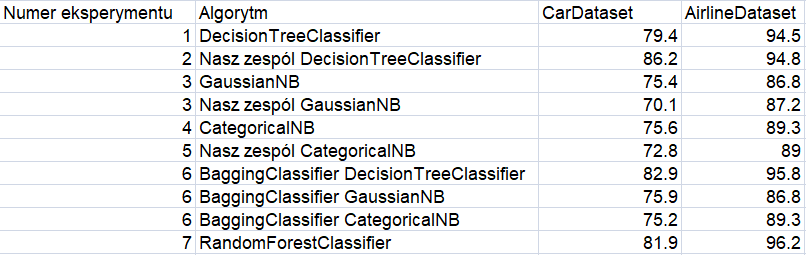